# Part 1D: UMAP

In this notebook we perform preprocessing, clustering, and then apply the UMAP method at the end.

## Preprocessing

In [1]:
import polars as pl
import pandas as pd 

# Load datasets
demo = pd.read_csv("DemoStats.csv")
spend = pd.read_csv("HouseholdSpend.csv")

# Display basic info
print("DemoStats shape:", demo.shape)
print("HouseholdSpend shape:", spend.shape)
print("\nDemoStats preview:\n", demo.head())
print("\nHouseholdSpend preview:\n", spend.head())

# Check for a shared key column
print("\nCommon columns:", set(demo.columns).intersection(set(spend.columns)))

DemoStats shape: (868970, 736)
HouseholdSpend shape: (868970, 246)

DemoStats preview:
      CODE     GEO  ECYASQKM  ECYALSQKM  ECYBASPOP  ECYBASHHD  ECYBASHPOP  \
0  A0A0A0  FSALDU         0          0          0          0           0   
1  A0A1A0  FSALDU         0          0         55         33          55   
2  A0A1B0  FSALDU         0          0        588        243         588   
3  A0A1C0  FSALDU         0          0       1793        709        1791   
4  A0A1E0  FSALDU         0          0        452        176         449   

   ECYBAS12P  ECYBAS15P  ECYBAS18P  ...  ECYGEN1GEN  ECYGEN2GEN  ECYGEN3GEN  \
0          0          0          0  ...           0           0           0   
1         55         55         55  ...           0           0          55   
2        561        512        475  ...          11          14         563   
3       1548       1465       1405  ...          50          32        1709   
4        415        389        357  ...          10         

In [2]:
# Merge on common columns
data = pd.merge(demo, spend, on=["CODE", "GEO"], how="inner")

# Drop identifier columns
data = data.drop(columns=["CODE", "GEO"])
print(data.shape)


import numpy as np
# We sample the data to make it easier to work with
sample_size = 20000
rng = np.random.default_rng(seed=42)
sample_idx = rng.choice(data.shape[0], size=sample_size, replace=False)
data = data.iloc[sample_idx]

(868970, 978)


Now let's look into columns with null values and deal with them based on what we find.

In [3]:
# Check for non-numerical columns
non_numerical_cols = len(data.select_dtypes(exclude=['number']).columns)
print(f'Found {non_numerical_cols} non-numerical columns.\n')

# Columns with at least one null
null_columns = data.columns[data.isnull().any()]

# Total number of rows
total_rows = len(data)

# Count nulls and percent nulls
null_counts = data[null_columns].isnull().sum()
null_percent = null_counts / total_rows * 100

# Percent of non-null rows that are zero
zero_percent = (data[null_columns] == 0).sum() / data[null_columns].notnull().sum() * 100

# Combine all into one DataFrame
null_summary = pd.DataFrame({
    'Null Count': null_counts,
    'Percent Nulls': null_percent,
    'Percent Zeros': zero_percent
})

print(null_summary)

Found 0 non-numerical columns.

           Null Count  Percent Nulls  Percent Zeros
ECYPTAMED        2033         10.165            0.0
ECYPMAMED        2272         11.360            0.0
ECYPFAMED        3017         15.085            0.0
ECYHTAMED        2146         10.730            0.0
ECYHMAMED        2386         11.930            0.0
ECYHFAMED        3150         15.750            0.0
ECYMTNMED        2146         10.730            0.0


There are seven columns with large amounts of null values, but not large enough to simply drop them right away. Let's decide whether to drop them or not based on whether they show any correlation with the target variable.

In [4]:
# Create target variable
temp_df = pd.DataFrame()
temp_df["target"] = data["HSEP001S"] / data["HSHNIAGG"]

# Compare variables with null values
cols_to_compare = data[['ECYPTAMED', 'ECYPMAMED', 'ECYPFAMED',
                        'ECYHTAMED', 'ECYHMAMED', 'ECYHFAMED', 'ECYMTNMED']]

# Calculate correlation with target
correlations = cols_to_compare.corrwith(temp_df['target']).dropna()
correlation_table = correlations.sort_values(key=abs, ascending=False).reset_index()
correlation_table.columns = ['Variable', 'Correlation with Target']

print(correlation_table.to_string(index=False))

 Variable  Correlation with Target
ECYMTNMED                -0.522651
ECYHTAMED                -0.310663
ECYPTAMED                -0.310490
ECYHFAMED                -0.297318
ECYPFAMED                -0.293100
ECYPMAMED                -0.243312
ECYHMAMED                -0.243250


All of the columns with null values seem to have meaningfuly enough correlation with the target such that we should keep them and impute the null values. Let's do that next.

In [5]:
# Creates dict of the column names and the median of the column
dict_median = {column: data[column].median() for column in null_columns}
print(dict_median)

# Replace the NA/NaN values with the median of the column
data.fillna(value=dict_median, inplace=True)

{'ECYPTAMED': 41.3, 'ECYPMAMED': 40.0, 'ECYPFAMED': 42.5, 'ECYHTAMED': 41.0, 'ECYHMAMED': 40.0, 'ECYHFAMED': 42.5, 'ECYMTNMED': 55.0}


Now we will read the metadata files to find any variables related to the target variables, including the target variables themselves and save them for dropping in order to prevent data leakage.

In [6]:
household_meta = pd.read_csv("Documentation/HouseholdSpend 2024 - Metadata.csv")
demostats_meta = pd.read_csv("Documentation/DemoStats 2024 - Metadata.csv")

# Define keywords
keywords = ['insurance', 'pension', 'retirement', 'income tax', 'income', 'RRIF']

# Filter by keyword in description
def find_related_vars(df, desc_col='Description', var_col='Variable'):
    # Match keyword in description
    mask = df[desc_col].str.lower().str.contains('|'.join(keywords), na=False)
    related = df[mask].copy()
    related_vars = related[var_col].unique()

    # Include derived variables by prefix match
    derived_mask = df[var_col].apply(lambda x: any(str(x).startswith(prefix) for prefix in related_vars))
    derived = df[derived_mask]

    # Combine and filter columns
    combined = pd.concat([related, derived]).drop_duplicates()
    return combined[['Variable', 'Description', 'Category', 'Root Formula']]

# Find matching variables
demo_related = find_related_vars(demostats_meta)
spend_related = find_related_vars(household_meta)

# Extract variable names for dropping
drop_vars = list(demo_related['Variable'].unique()) + list(spend_related['Variable'].unique())
drop_vars = [str(var).strip() for var in drop_vars]

print("\nTotal variables marked for dropping:", len(drop_vars))
print("Variable names:\n", drop_vars)



Total variables marked for dropping: 176
Variable names:
 ['EHYHRI_020', 'EHYHRI2040', 'EHYHRI4060', 'EHYHRI6080', 'EHYHRIX100', 'EHYHRI100P', 'EHYHRIX125', 'EHYHRIX150', 'EHYHRIX200', 'EHYHRI200P', 'EHYHRIX300', 'EHYHRI300P', 'EHYHRIAVG', 'EHYHRIMED', 'EHYHRIAGG', 'EHYHNI_020', 'EHYHNI2040', 'EHYHNI4060', 'EHYHNI6080', 'EHYHNIX100', 'EHYHNI100P', 'EHYHNIX125', 'EHYHNIX150', 'EHYHNIX200', 'EHYHNI200P', 'EHYHNIX300', 'EHYHNI300P', 'EHYHNIAVG', 'EHYHNIMED', 'EHYHNIAGG', 'ECYHRI_020', 'ECYHRI2040', 'ECYHRI4060', 'ECYHRI6080', 'ECYHRIX100', 'ECYHRI100P', 'ECYHRIX125', 'ECYHRIX150', 'ECYHRIX200', 'ECYHRI200P', 'ECYHRIX300', 'ECYHRI300P', 'ECYHRIAVG', 'ECYHRIMED', 'ECYHRIAGG', 'ECYHNI_020', 'ECYHNI2040', 'ECYHNI4060', 'ECYHNI6080', 'ECYHNIX100', 'ECYHNI100P', 'ECYHNIX125', 'ECYHNIX150', 'ECYHNIX200', 'ECYHNI200P', 'ECYHNIX300', 'ECYHNI300P', 'ECYHNIAVG', 'ECYHNIMED', 'ECYHNIAGG', 'ECYPNIHP15', 'ECYPNININ', 'ECYPNIWIN', 'ECYPNIAVG', 'ECYINDFINA', 'P3YHRI_020', 'P3YHRI2040', 'P3YHRI4060', 'P3

We've found 176 variables that are related to the target variables, many of which are demographic statistics that would allow the target variables to be reverse engineered, at least to some degree. So let's drop these variables, but note that the actual provied data does not actually include all these variables since the metadata file and the actual data are out of sync, as explained by TAs already. Let's just note the ones that we didn't find in the data and then remove the ones that we did find!

In [7]:
found = [col for col in drop_vars if col in data.columns]
missing = [col for col in drop_vars if col not in data.columns]

print(f"\nFound {len(found)} of {len(drop_vars)} drop_vars in the data.")
print("Examples not found:", missing[:10])

before_cols = data.shape[1]
# Drop columns
data = data.drop(columns=[col for col in drop_vars if col in data.columns])
after_cols = data.shape[1]

print(f"\nDropped {before_cols - after_cols} columns from data.")


Found 47 of 176 drop_vars in the data.
Examples not found: ['EHYHRI_020', 'EHYHRI2040', 'EHYHRI4060', 'EHYHRI6080', 'EHYHRIX100', 'EHYHRI100P', 'EHYHRIX125', 'EHYHRIX150', 'EHYHRIX200', 'EHYHRI200P']

Dropped 47 columns from data.


Finally, we want to check for outliers in the columns, for each outlier we find outside the IQR range, we will set it to the lower and upper bound of the IQR respectively. We chose IQR here because the z-score clipping method is sensitive to datasets that are very skewed and since we don't know all the details about how skewed and strong the outliers in this dataset are, it's better to be conservative and just use the robust IQR method.

In [8]:
# IQR-based winsorization
for col in data.select_dtypes(include='number').columns:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    data[col] = data[col].clip(lower=lower, upper=upper)

print("Outliers have been capped using IQR method (1.5 * IQR).")

Outliers have been capped using IQR method (1.5 * IQR).


Finally, we will remove columns with very low variance (essentially repeated data and noise), and then scale the data.

In [9]:
from sklearn.preprocessing import StandardScaler

# Drop columns with all same values (including all zeros)
low_variance_cols = data.columns[data.nunique() <= 1]
data = data.drop(columns=low_variance_cols)
print(f"Dropped {len(low_variance_cols)} low-variance columns.")

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
data_scaled_df = pd.DataFrame(data_scaled, columns=data.columns)

# Output shape of cleaned and scaled data
print("Final cleaned shape:", data_scaled_df.shape)

Dropped 304 low-variance columns.
Final cleaned shape: (20000, 627)


## K-Means Clustering

Since the dataset is so large, and our machines are not so powerful in comparison, we can use the elbow and silhouette methods on a sample of the data to get an idea of what the number of clusters should be. Based on that we can run one (or just much fewer) KMeans on the full dataset.

In [ ]:
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from yellowbrick.cluster import KElbowVisualizer

os.makedirs("figures", exist_ok=True)
plt.rcParams.update({'font.size': 12})


# Elbow Method
model = KMeans(random_state=42, n_init='auto')
visualizer = KElbowVisualizer(model, k=(2, 10), locate_elbow=True, timings=False)
visualizer.fit(data)
visualizer.show(outpath="figures/elbow_plot.png")
optimal_k = visualizer.elbow_value_

# Silhouette plots for k = 2 to 5
range_n_clusters = list(range(2, 6))
silhouette_scores = []

for k in range_n_clusters:
    fig, ax = plt.subplots(figsize=(8, 5))

    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(data)

    silhouette_avg = silhouette_score(data, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    sample_silhouette_values = silhouette_samples(data, cluster_labels)

    y_lower = 10
    for i in range(k):
        ith_vals = sample_silhouette_values[cluster_labels == i]
        ith_vals.sort()
        size_i = ith_vals.shape[0]
        y_upper = y_lower + size_i

        color = cm.nipy_spectral(float(i) / k)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_vals,
                         facecolor=color, edgecolor=color, alpha=0.7)
        ax.text(-0.06, y_lower + 0.5 * size_i, str(i))

        y_lower = y_upper + 10

    ax.axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=1.5)
    ax.set_title(f"Silhouette Plot for k = {k}")
    ax.set_xlabel("Silhouette coefficient values")
    ax.set_ylabel("Cluster")
    ax.set_yticks([])
    ax.set_xlim([-0.1, 0.75])
    ax.grid(True, axis='x', linestyle=':', alpha=0.5)
    plt.tight_layout()

    plt.savefig(f"figures/silhouette_k{k}.png")
    plt.show()

# Silhouette Score Line Plot
plt.figure(figsize=(6, 4))
plt.plot(range_n_clusters, silhouette_scores, marker='o', color='orange', linewidth=2)
plt.title("Average Silhouette Score")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.savefig("figures/silhouette_scores.png")
plt.close()

The Elbow method and the Silhouette scores are essentially in complete agreement about the optimal number of clusters.  Both seem to indicate some clustering at n=2 clusters, but there is also a strong case to be made for n=3 by them both. The truth is that they don't seem to indicate a perfectly optimal number, and based on the silhouette plots we can see that even at n=2 or n=3, the data isn't well clustered, perhaps suggesting that this dataset doesn't have very many or meaningful "low-density zones" which are a requirement for clustering methods such as K-Means. We'll go ahead and apply K-Means using n=3 and save the results for now so we can colour the PCA plots later using the respective cluster labels.

In [11]:
kmeans_3 = KMeans(n_clusters=3, random_state=42, n_init='auto')
labels_3 = kmeans_3.fit_predict(data_scaled_df)

clustered_df = pd.DataFrame(data_scaled_df, columns=[f"var_{i}" for i in range(data_scaled_df.shape[1])])
clustered_df["cluster_3"] = labels_3

## UMAP

We will use UMAP as another dimensionality reduction method to visualize the clusters.

In [12]:
import umap.umap_ as umap
import seaborn as sns

# Using a smaller sample for UMAP since it is slower
sample_size = 20000
rng = np.random.default_rng(seed=42)
sample_idx = rng.choice(data_scaled_df.shape[0], size=sample_size, replace=False)
data_scaled_df = data_scaled_df.iloc[sample_idx]
labels_3 = labels_3[sample_idx]

# Function to run UMAP
def run_umap(data2, n_neighbors=40, min_dist=1, spread=1.5, metric='euclidean', n_epochs=100, verbose=False):
    reducer = umap.UMAP(n_neighbors=n_neighbors,
                        n_components=2,
                        metric=metric,
                        random_state=42,
                        min_dist=min_dist,
                        spread=spread,
                        low_memory=False,
                        n_epochs=n_epochs,
                        verbose=verbose,
                        n_jobs=-1)
    return reducer.fit_transform(data2)

# Draw the UMAP plot
def plot_umap(embedding, labels, title):
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=labels)
    plt.title(title)
    plt.xlabel("UMAP Component 1")
    plt.ylabel("UMAP Component 2")
    plt.show()

# Plot UMAP in subplots
def plot_umap_subplot(embedding, labels, title, ax):
    sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=labels, ax=ax, legend=False, s=10)
    ax.set_title(title, fontsize=10)
    ax.set_xlabel("Component 1", fontsize=8)
    ax.set_ylabel("Component 2", fontsize=8)
    ax.tick_params(axis='both', labelsize=7)


We will run UMAP with a few different hyperparameters to see how they affect the results and for now we will use 100 epochs, but we will increase it later for the final run. We will also try different metrics to see which one works the best.

/Users/sepehr/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/sepehr/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/sepehr/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/sepehr/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/sepehr/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/sepehr/anac

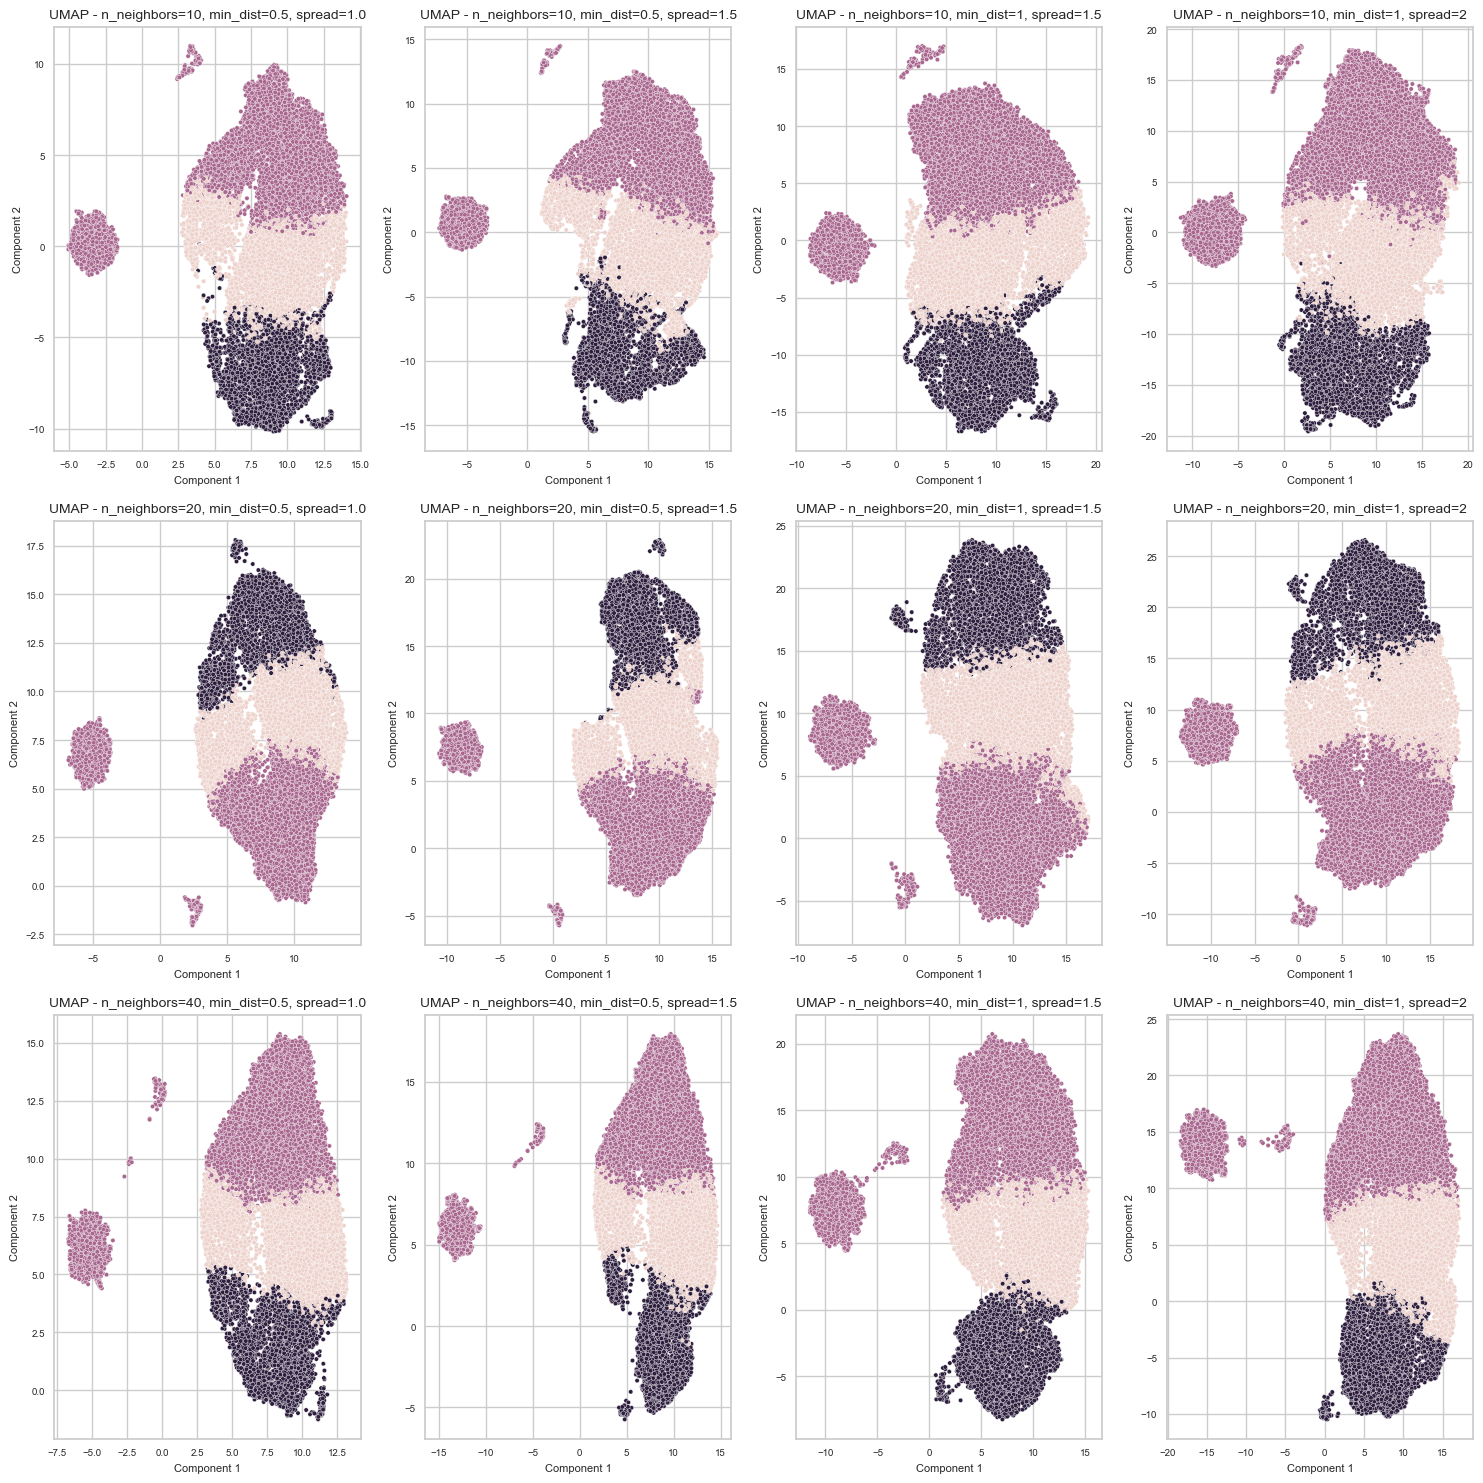

In [13]:
# Different hyperparameters to test
neighbors = [10, 20, 40]
min_dists = [0.5, 1]
spreads = [0.5, 1]

total_plots = len(neighbors) * len(min_dists) * len(spreads)
cols = 4
rows = total_plots // cols + (total_plots % cols > 0)

# We run the UMAP for euclidean metric first
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

plot_index = 0

for n_neighbors in neighbors:
    for min_dist in min_dists:
        for spread in spreads:
            embedding = run_umap(data_scaled_df, n_neighbors=n_neighbors, min_dist=min_dist, spread=spread + min_dist)
            plot_umap_subplot(embedding, labels_3, f"UMAP - n_neighbors={n_neighbors}, min_dist={min_dist}, spread={spread + min_dist}", axes[plot_index])
            plot_index += 1
            
fig.tight_layout()
plt.show()

/Users/sepehr/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/sepehr/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/sepehr/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/sepehr/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/sepehr/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/sepehr/anac

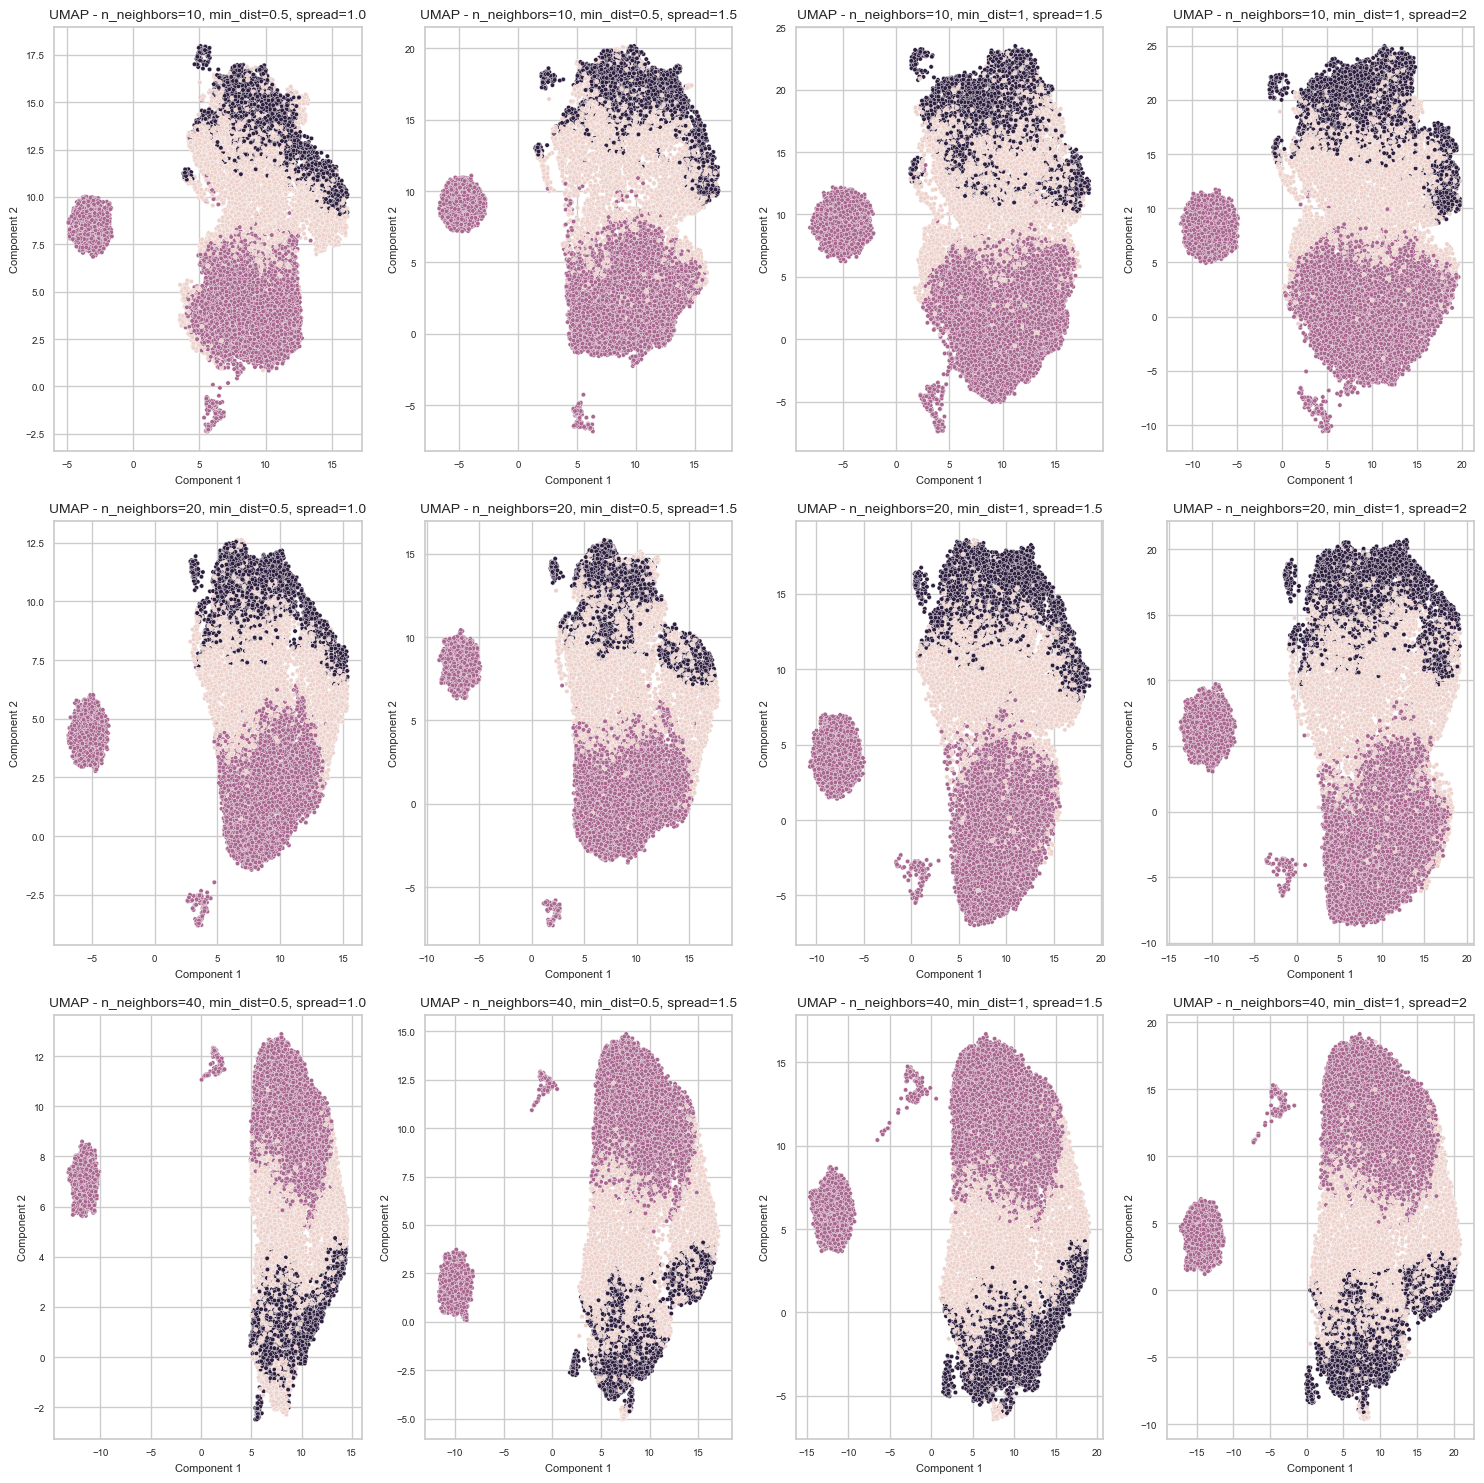

In [14]:
# same but with cosine metric
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

plot_index = 0

for n_neighbors in neighbors:
    for min_dist in min_dists:
        for spread in spreads:
            embedding = run_umap(data_scaled_df, n_neighbors=n_neighbors, min_dist=min_dist, spread=spread + min_dist, metric='cosine')
            plot_umap_subplot(embedding, labels_3, f"UMAP - n_neighbors={n_neighbors}, min_dist={min_dist}, spread={spread + min_dist}", axes[plot_index])
            plot_index += 1

fig.tight_layout()
plt.show()

/Users/sepehr/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/sepehr/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/sepehr/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/sepehr/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/sepehr/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/sepehr/anac

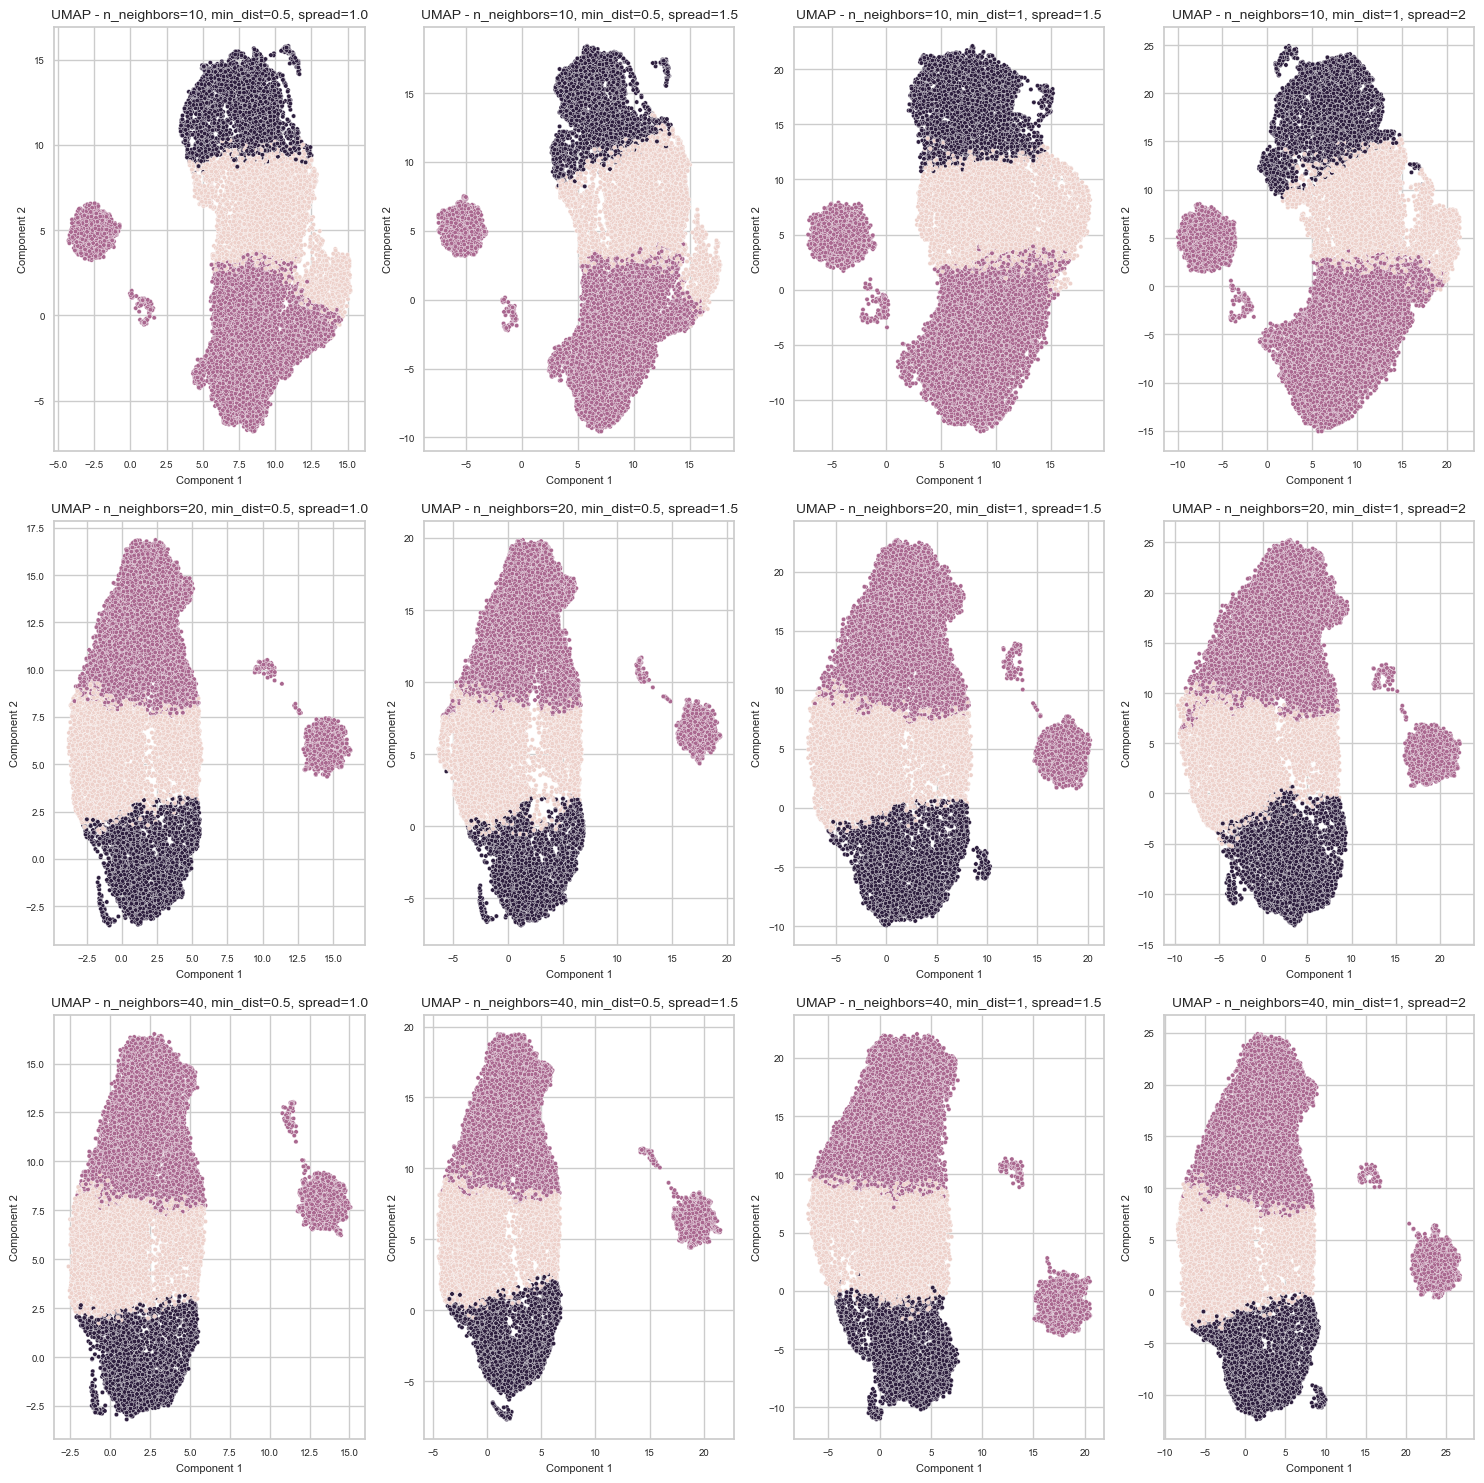

In [15]:
# same but with manhattan metric
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

plot_index = 0

for n_neighbors in neighbors:
    for min_dist in min_dists:
        for spread in spreads:
            embedding = run_umap(data_scaled_df, n_neighbors=n_neighbors, min_dist=min_dist, spread=spread + min_dist, metric='manhattan')
            plot_umap_subplot(embedding, labels_3, f"UMAP - n_neighbors={n_neighbors}, min_dist={min_dist}, spread={spread + min_dist}", axes[plot_index])
            plot_index += 1

fig.tight_layout()
plt.show()

In [19]:
# last run with the best parameters and higher epochs
embedding = run_umap(data_scaled_df, n_neighbors=40, min_dist=1, spread=1.5, n_epochs=1000, verbose=True, metric="manhattan")

/Users/sepehr/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/sepehr/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(low_memory=False, metric='manhattan', min_dist=1, n_epochs=1000, n_jobs=1, n_neighbors=40, random_state=42, spread=1.5, verbose=True)
Sun Apr 20 23:23:54 2025 Construct fuzzy simplicial set
Sun Apr 20 23:23:54 2025 Finding Nearest Neighbors
Sun Apr 20 23:23:54 2025 Building RP forest with 12 trees
Sun Apr 20 23:23:54 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Sun Apr 20 23:24:03 2025 Finished Nearest Neighbor Search
Sun Apr 20 23:24:03 2025 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs
Sun Apr 20 23:25:21 2025 Finished embedding


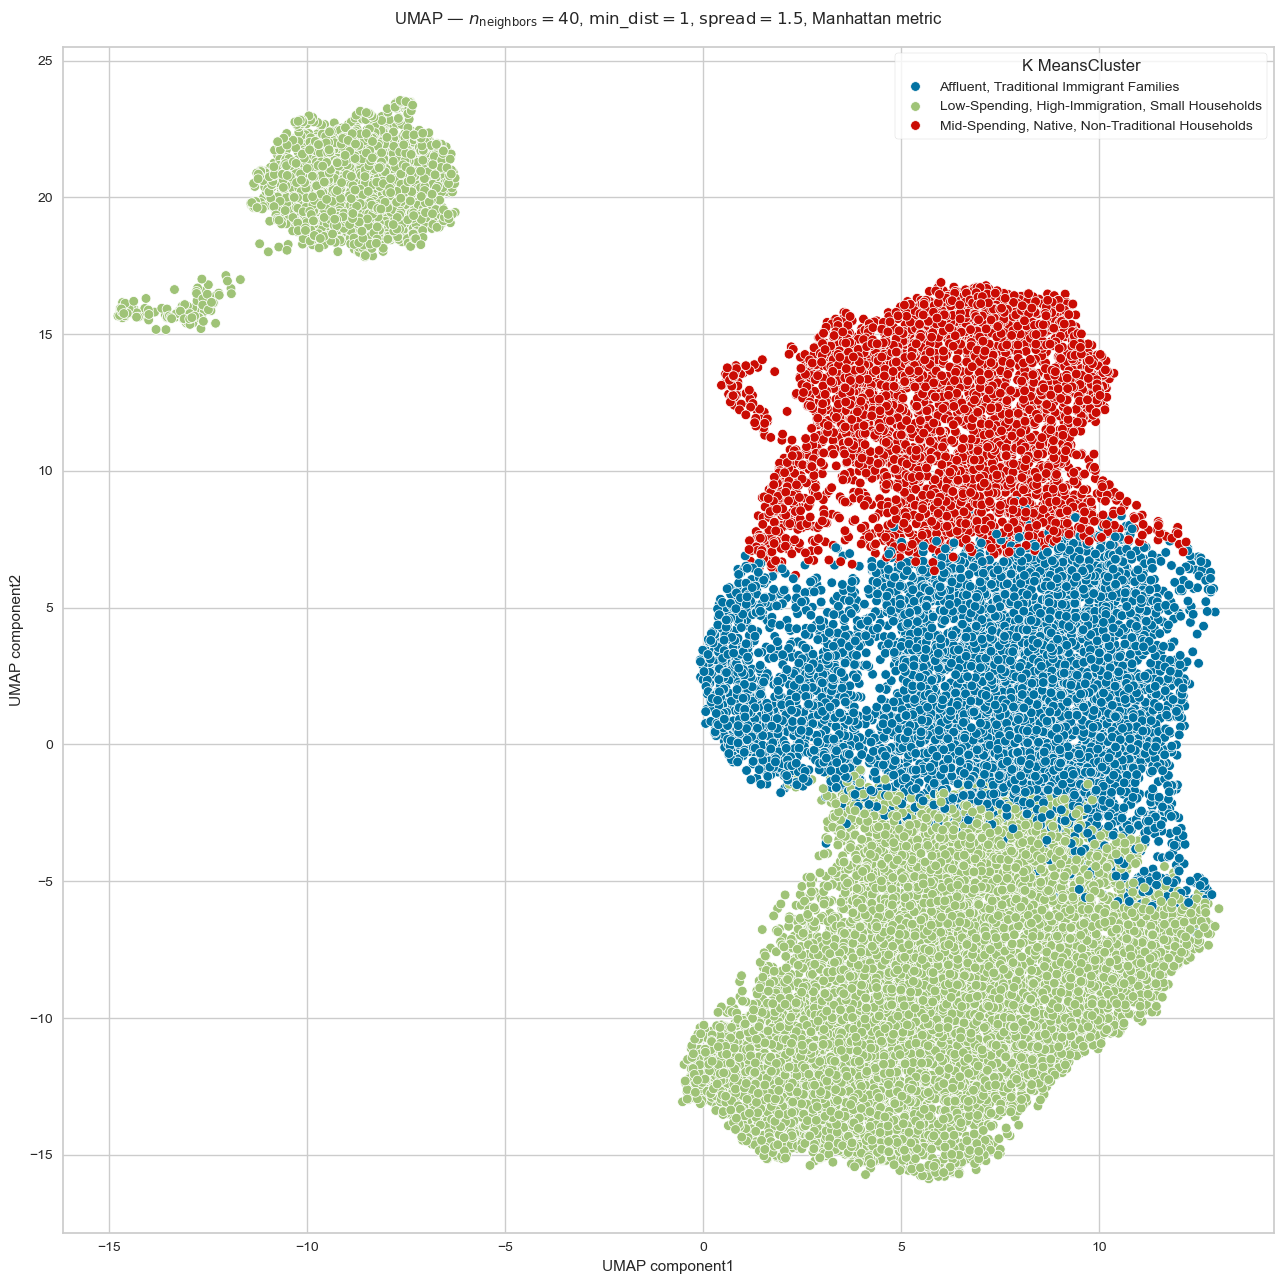

In [33]:
# plot the UMAP results
label_map = {
    0: "Affluent, Traditional Immigrant Families",
    1: "Low-Spending, High-Immigration, Small Households",
    2: "Mid-Spending, Native, Non-Traditional Households"
}

plot_df = pd.DataFrame({
    "UMAP‑1": embedding[:, 0],
    "UMAP‑2": embedding[:, 1],
    "Cluster": [label_map[l] for l in labels_3]
})

plt.figure(figsize=(13, 13))
sns.scatterplot(
    data=plot_df,
    x="UMAP‑1",
    y="UMAP‑2",
    hue="Cluster"
)

plt.title("UMAP — $n_{\\text{neighbors}}=40$, $\\text{min\\_dist}=1$, "
          "$\\text{spread}=1.5$, Manhattan metric", pad=15)
plt.xlabel("UMAP component1")
plt.ylabel("UMAP component2")
plt.legend(title="K MeansCluster", frameon=True)
plt.tight_layout()
plt.show()
